This notebook recreates Figure 4 in Merdith et al. (2019) 'Rift and Plate Boundary Evolution across Two Supercontinent Cycles'. 

It loops through plate reconstructions and extracts the area, perimeter and count of continents at any one time.  We then plot the area:perimeter ratio to see how connected the continental lithosphere is through time.

It should be (reasonably) adaptable for all times, provided you have a plate model (for continental area).  Some sort of secondary polygon that represents teh best estimate of continental extent is also useful (e.g. continent-ocean boundaries).

Parts of this code was originally written by Simon Williams (https://github.com/siwill22) and John Cannon, and has been slightly altered by me.


References

Domeier, M., 2016. A plate tectonic scenario for the Iapetus and Rheic oceans. Gondwana Research, 36, pp.275–295.

Domeier, M., 2018. Early Paleozoic tectonics of Asia: towards a full-plate model. Geoscience Frontiers, 9(3), pp.789–862.

Matthews, K.J., Maloney, K.T., Zahirovic, S., Williams, S.E., Seton, M. and Müller, R.D., 2016. Global plate boundary evolution and kinematics since the late Paleozoic. Global and Planetary Change, 146, pp.226–250.

Merdith, A.S., Collins, A.S., Williams, S.E., Pisarevsky, S., Foden, J.D., Archibald, D.B., Blades, M.L., Alessio, B.L., Armistead, S., Plavsa, D., Clark, C., and Müller, R.D. 2017. A full-plate global reconstruction of the Neoproterozoic. Gondwana Research, 50, pp.84–134.

Merdith, A.S., Williams, S.E., Brune, S., Collins, A.S. and Müller, R.D. 2019. Rift and Plate Boundary Evolution across Two Supercontinent Cycles. Global and Planetary Change, 173, pp.1–14 



In [14]:
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import numpy as np
import os
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from skimage import measure
import csv
import itertools
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [3]:
#this function creates new polygons that are the amalgamation of a series of overlapping polygons
#in order to make 'supercontinent polyogns'
def run_grid_pip(time,points,polygons,rotation_model):
    
    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)
    
    rpolygons = []
    for polygon in reconstructed_polygons:
        if polygon.get_reconstructed_geometry():
            rpolygons.append(polygon.get_reconstructed_geometry())

    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    bi = np.array(zval).reshape(181,361)
    
    return bi

In [4]:
 def lamo(bi):
    #
    #so this sucks
    #essentialy at time slices where the supercontinent polygon covers all of one
    #side of our array, python can't tell which is in and which is out
    #so we arbitarilly buffer the size of our arrays below to make them one entry bigger
    #so we can get what we need, then we undo it later
    #

    #pad
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3,0.1, fully_connected='low')
    contour_polygons = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
    
    return contour_polygons

In [5]:
#setbasedir for loading reconstruction files
basedir = './Sample_data/'

#Matthews et al. (2016)
Mat16_rotation_model = pygplates.RotationModel('%sMat16_410-0Ma.rot' % basedir)
Mat16_polygons = pygplates.FeatureCollection('%sMat16_PresentDay_ContinentalPolygons.gpml' % basedir)
Mat16_topologies = ['%sMat16_Mesozoic-Cenozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_Paleozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_TopologyBuildingBlocks.gpml' % basedir]
Mat16_COBs = pygplates.FeatureCollection('%sMat16_COBs.gpml' % basedir)

#Domeier models
Dom18_rotation_model = pygplates.RotationModel('%sDom18_merge-Rotation_ASM.rot' % basedir)
Dom18_polygons = pygplates.FeatureCollection('%sDom18_merge-Land_ASM.gpml' % basedir)
Dom18_topologies = ['%sDom18_merge-Ridges_ASM.gpml' % basedir,
                  '%sDom18_merge-Topologies_ASM.gpml' % basedir,
                  '%sDom18_merge-Transforms_ASM.gpml' % basedir,
                  '%sDom18_merge-Trenches_ASM.gpml' % basedir,
                  '%sDom18_merge-ArbitaryLines_ASM.gpml' % basedir]
Dom_COBs = pygplates.FeatureCollection('%sDom18_merge-COBs.gpml' % basedir)

#Merdith model
Mer17_rotation_model = pygplates.RotationModel('%sMer17_rotations.rot' % basedir)
Mer17_polygons = pygplates.FeatureCollection('%sMer17_polygons.gpml' % basedir)
Mer17_topologies = ['%sMer17_Transforms.gpml' % basedir,
                  '%sMer17_Topologies.gpml' % basedir,
                  '%sMer17_Divergence.gpml' % basedir,
                  '%sMer17_Convergence.gpml' % basedir]
Mer17_COBs = pygplates.FeatureCollection('%sMer17_COBs.gpml' % basedir)

#we want two different area thresholds to see the difference
large_area_threshold = 500000
small_area_threshold = 10000

#generate points for creating supercontinent polygons
multipoints = create_gpml_regular_long_lat_mesh(1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()

#set date line wrapper for plotting maps
date_line_wrapper = pygplates.DateLineWrapper()

In [6]:
#this confirms that all features within our COB terranes are actually polygons and not multipoints in disguise
polygons = []
for feature in Mat16_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Mat16_COBs = pygplates.FeatureCollection(polygons)

polygons = []
for feature in Dom_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Dom18_COBs = pygplates.FeatureCollection(polygons)

polygons = []
for feature in Mer17_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Mer17_COBs = pygplates.FeatureCollection(polygons)

Extract area of and number of continents from model

In [9]:
#extract data from plate models
#it returns at each time step the area/perimeter of each plate storaed
large_plate_area = [] 
large_plate_perimeter = []
small_plate_area = [] 
small_plate_perimeter = []

times = np.arange(0,1001,1)

for time in times:
    contour_polygons = []
    print (time)
    time = int(time)
    if time >= 0 and time <= 410:
        bi = run_grid_pip(time,points,Mat16_COBs,Mat16_rotation_model)
    elif time > 410 and time <= 500:
        bi = run_grid_pip(time,points,Dom18_COBs,Dom18_rotation_model)
    else:
        bi = run_grid_pip(time,points,Mer17_COBs,Mer17_rotation_model)        

    contour_polygons = lamo(bi)
    
    tmp_large_plate_area = []
    tmp_large_plate_perimeter = []
    tmp_small_plate_area = []
    tmp_small_plate_perimeter = []

    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > large_area_threshold:
            tmp_large_plate_area.append(pg.get_area()*pygplates.Earth.mean_radius_in_kms**2)
            tmp_large_plate_perimeter.append(pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms)
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > small_area_threshold:
            tmp_small_plate_area.append(pg.get_area()*pygplates.Earth.mean_radius_in_kms**2)
            tmp_small_plate_perimeter.append(pg.get_arc_length()*pygplates.Earth.mean_radius_in_kms)
    
    #append to final list
    large_plate_area.append(tmp_large_plate_area)
    large_plate_perimeter.append(tmp_large_plate_perimeter)
    small_plate_area.append(tmp_small_plate_area)
    small_plate_perimeter.append(tmp_small_plate_perimeter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
#sum across timesteps
summed_timesteps_large_area = []
for n,i in enumerate(large_plate_area):
    summed_timesteps_large_area.append(sum(i))
    
summed_timesteps_large_perimeter = []
for n,j in enumerate(large_plate_perimeter):
    summed_timesteps_large_perimeter.append(sum(j))
    
summed_timesteps_small_area = []
for n,i in enumerate(small_plate_area):
    summed_timesteps_small_area.append(sum(i))
    
summed_timesteps_small_perimeter = []
for n,j in enumerate(small_plate_perimeter):
    summed_timesteps_small_perimeter.append(sum(j))

In [16]:
heads = ['time', 
         'plate_area_500000',
         'plate_perimeter_500000',
         'plate_area_10000',
         'plate_perimeter_10000']
results_1000_0_MER19 = [times,
                         summed_timesteps_large_area,
                         summed_timesteps_large_perimeter,
                         summed_timesteps_small_area,
                         summed_timesteps_small_perimeter]
results_1000_0_MER19 = pd.DataFrame(results_1000_0_MER19).transpose()
results_1000_0_MER19.columns = heads
results_1000_0_MER19.to_csv('%sarea_perimeter_1000_0_MER19.csv' % basedir, index=False)

In [12]:
#save csv
values = zip(times,
                            summed_timesteps_large_area,
                            summed_timesteps_large_perimeter,
                            summed_timesteps_small_area,
                            summed_timesteps_small_perimeter)
                      
                      
    
with open('%s/area_perimeter_1000_0_MER19.csv' % basedir, mode='wb') as myfile:
    rift_writer = csv.writer(myfile, delimiter=',', quoting=csv.QUOTE_ALL)
    rift_writer.writerow(('time', 
                          'plate_area_500000',
                          'plate_perimeter_500000',
                          'plate_area_10000',
                          'plate_perimeter_10000'))
    for val in values:
        rift_writer.writerow(val)

TypeError: a bytes-like object is required, not 'str'

In [17]:
#we want the ratio because of the difference in resolution between the younger models and the older ones
ratio_large = []
for a,p in zip(summed_timesteps_large_area, summed_timesteps_large_perimeter):
    ratio_large.append(p/a)
    
ratio_small = []
for a,p in zip(summed_timesteps_small_area, summed_timesteps_small_perimeter):
    ratio_small.append(p/a)

In [18]:
#to normalise?
norm = [float(i)/max(ratio_large) for i in ratio_large]
norm2 = [float(i)/max(ratio_small) for i in ratio_small]

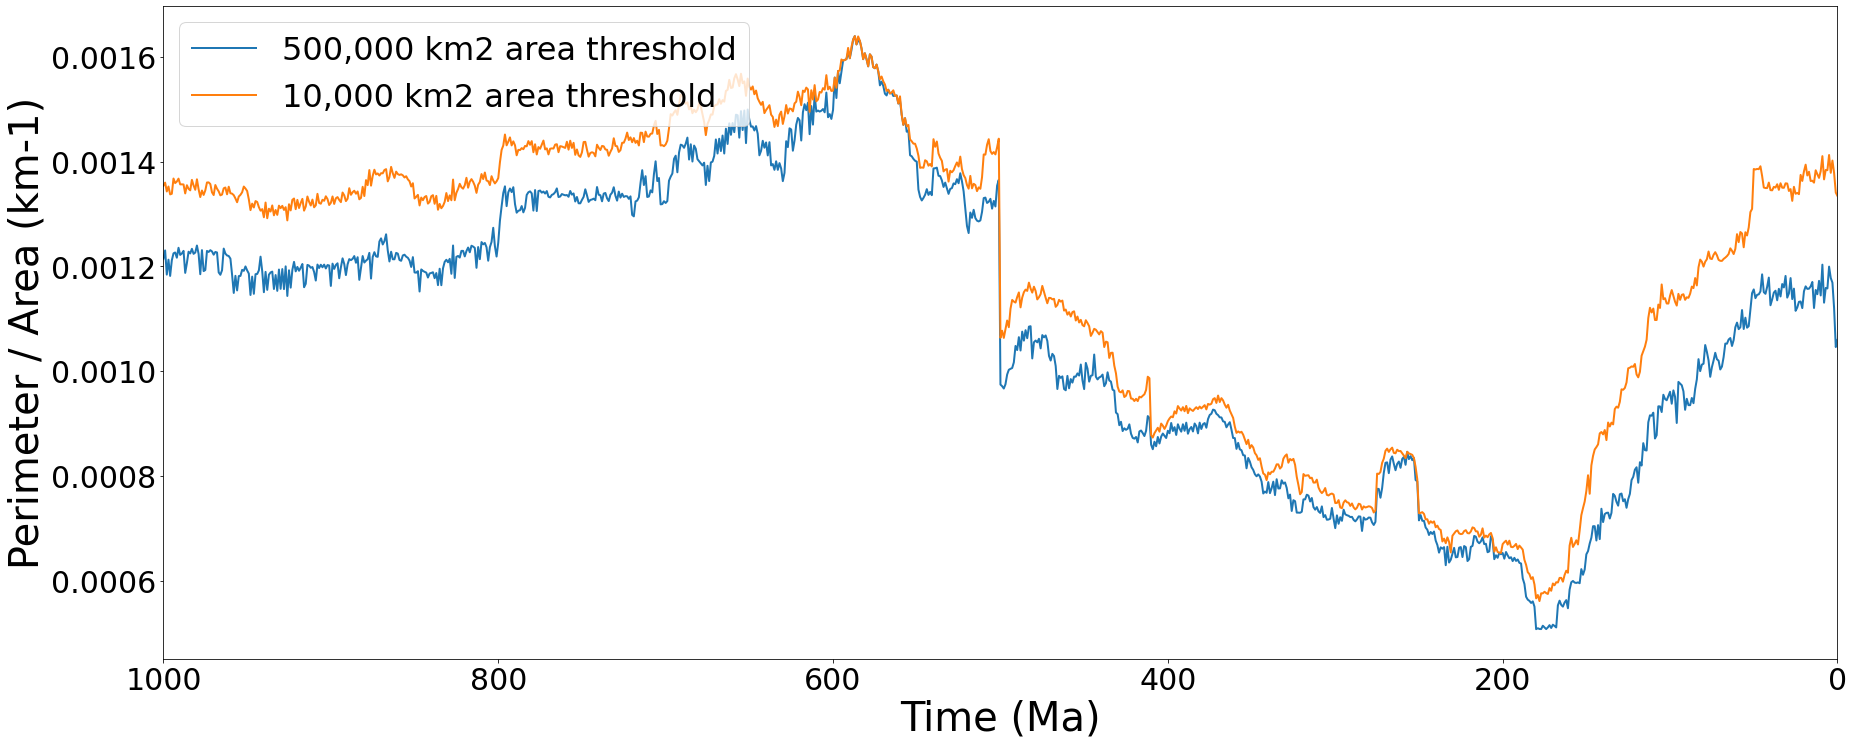

In [19]:
#Figure 4b from Merdith et al. 2019
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax.plot(times,ratio_large, lw=2, label='500,000 km2 area threshold')
ax.plot(times,ratio_small, lw=2, label='10,000 km2 area threshold')
ax.set_xlim(1000,0)
#ax.set_ylim(0, 14)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.set_xlabel('Time (Ma)', fontsize=40)
ax.set_ylabel('Area (km2)', fontsize=40)
ax.set_ylabel('Perimeter / Area (km-1)', fontsize=40)
ax.legend(loc='upper left',fontsize=32,bbox_to_anchor=(0,1))

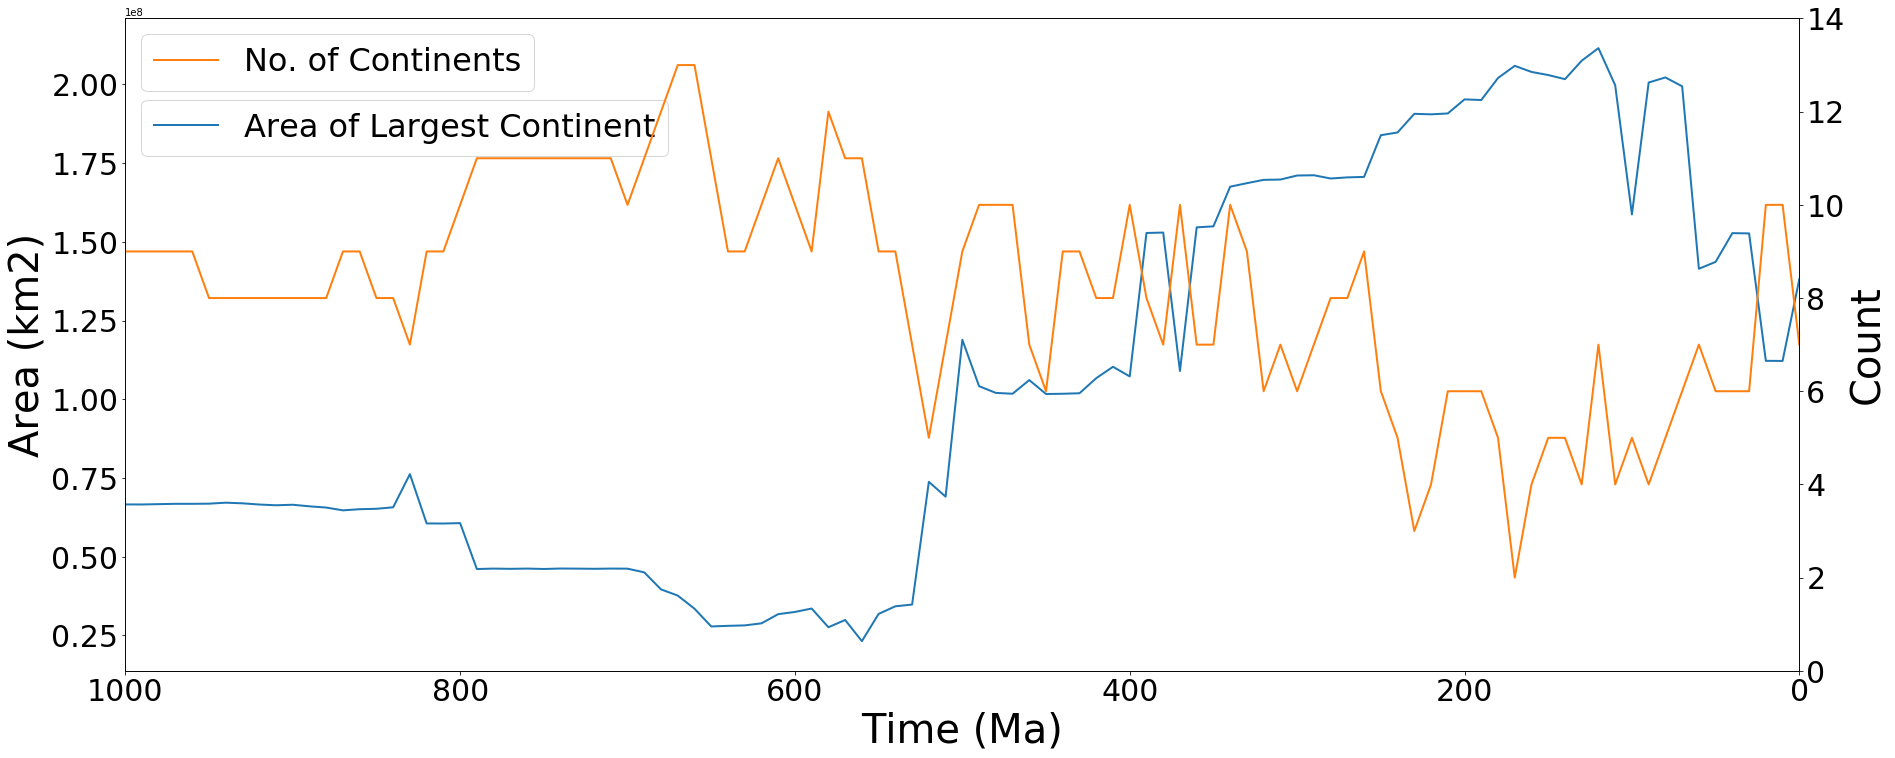

In [12]:
#Figure 4a from Merdith et al. 2019
max_area = []
no_conts = []
for imdex,timestep in enumerate(large_plate_area):
    max_area.append(max(timestep))
    no_conts.append(len(timestep))
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax2 = ax1.twinx()
ax1.plot(times,max_area, color='#1f77b4', lw=2, label='Area of Largest Continent')
ax2.plot(times,no_conts, color='#ff7f0e', lw=2, label='No. of Continents')
ax1.set_xlim(1000,0)
ax2.set_ylim(0, 14)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)
ax1.set_xlabel('Time (Ma)', fontsize=40)
ax1.set_ylabel('Area (km2)', fontsize=40)
ax2.set_ylabel('Count', fontsize=40)
ax1.legend(loc='upper left',fontsize=32,bbox_to_anchor=(0,.9))
ax2.legend(loc='upper left',fontsize=32,bbox_to_anchor=(0,1))